# Classification de nom avec un RNN char to char

Avant de démarrer cet exercice (directement repris des notebooks officiels pytorch), il est intéressant de prendre 2 minutes de recul pour considérer les applications qui peuvent être faites d'un tel travail.

La tâche étant parfaitement résolue par le notebook précédent, l'idée de celui-ci est de remettre le notebook d'origine dans le cadre standard défini dans les chapitres précédents. Vous êtes largement incité à comparer les notebooks au fur et à mesure de votre avancement.

ABORDER LES MODIFICATIONS DANS L'ORDRE PROPOSE

1. Les données seront chargées sous forme de liste d'entier [code fourni]
    - séparer les données en apprentissage et test 
    - ajouter un dataloader
2. Modification du modèle pour 
    - utiliser les modules RNN (LSTM...)
    - utiliser des embeddings (même pour du one-hot encoding)
3. Batch... + padding
4. Pondération des classes dans les tirages


In [1]:
# import standard + 
# 
import torch
from tqdm.autonotebook import tqdm
import os
import time
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
print(device)



mps


/var/folders/_h/xz4nr0h53dj3x3tygxjnzl540000gn/T/ipykernel_29294/1610587545.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from pathlib import Path
from IPython.display import display, HTML
from torch.utils.tensorboard import SummaryWriter

# Chemin vers TensorBoard
TB_PATH = "/tmp/logs/module-RNN"

# TENSORBOARD 
# usage externe de tensorboard: (1) lancer la commande dans une console; (2) copier-coller l'URL dans un navigateur
display(HTML("<h2>Informations</h2><div>Pour visualiser les logs, tapez la commande : </div>"))
print(f"tensorboard --logdir {Path(TB_PATH).absolute()}")
print("Une fois la commande lancer dans la console, copier-coller l'URL dans votre navigateur")

tensorboard --logdir /tmp/logs/module-RNN
Une fois la commande lancer dans la console, copier-coller l'URL dans votre navigateur


In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Classifying Names with a Character-Level RNN
==============================================================

**Author**: [Sean Robertson](https://github.com/spro)

Adds from Vincent Guigue


A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

``` {.sh}
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```




A. Preparing the Data
------------------

Included in the `data/names` directory are 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We\'ll end up with a dictionary of lists of names per language,
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.


In [4]:
# Pas de modification importante dans le chargement des données brutes
# noter malgré tout l'ajout de deux caractères spéciaux qui seront repris ensuite: PAD et SOS
# Les noms sont évocateurs... Si vous ne comprenez pas à quoi ils servent: demandez


from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,';_%"
PAD = len(all_letters)-1
# OPT : define a start of sequence letter = SOS
#<CORRECTION>
SOS = len(all_letters)-2
#</CORRECTION>
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [5]:
# vérification des données chargées

all_categories[0]

'Czech'

Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors


Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [7]:
##################
# MODIFICATION 1 : données => listes d'entiers [code fourni]
##################

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Turn a line into a list of integer
def lineToTensor(line):
    tensor = torch.tensor([letterToIndex(i) for i in line], dtype=torch.long)
    return tensor

letter = 'J'
print(letter, ':', letterToIndex(letter))

name = 'Jones'
print(name, ':', lineToTensor(name), lineToTensor(name).size())

J : 35
Jones : tensor([35, 14, 13,  4, 18]) torch.Size([5])


In [8]:
##################
# MODIFICATION 1 : données => listes d'entiers [code fourni]
##################
# # Vérification de la réversibilité des opérations

def tensorToName(x):
    name = ""
    for letter in x:
        name += all_letters[letter]
    return name


tensorToName(lineToTensor("John") )

'John'

In [9]:
##################
# MODIFICATION 1 : données => listes d'entiers [code fourni]
##################
# # vector => argmax => translation to country
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(torch.nn.functional.one_hot(torch.tensor(1),18))) # output from the previous box

('German', 1)


In [10]:
##################
# MODIFICATION 1 : données => listes d'entiers [code fourni]
##################
# from torch.utils.data import DataLoader, Dataset
from itertools import chain

alltensor=[]

labels = [[ i for name in category_lines[c]] for i,c in enumerate(all_categories)]
names  = [[ name for name in category_lines[c]] for i,c in enumerate(all_categories)]

# build a dataset (textrepr,label)
alllab = torch.tensor(list(chain.from_iterable(labels)), dtype = torch.long)
allx = [ lineToTensor(name).squeeze() for name in chain.from_iterable(names)]

# maxlen = -1
# for x in allx:
#     if len(x)>maxlen: maxlen = len(x)
# print(maxlen)


In [11]:
##################
# MODIFICATION 1 : données => listes d'entiers [code fourni]
##################
import torch
from torch.utils.data import Dataset, DataLoader

class NameDataset(Dataset):
    def __init__(self, input_tensors, label_tensors):
        assert len(input_tensors) == len(label_tensors), "Les listes d'entrée et d'étiquettes doivent avoir la même longueur"
        self.input_tensors = input_tensors
        self.label_tensors = label_tensors

    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, idx):
        return self.input_tensors[idx], self.label_tensors[idx]



In [12]:
##################
# MODIFICATION 1 : données => listes d'entiers [code fourni]
# Séparartion app / test
##################
# 
from torch.utils.data import random_split
Bsize = 128

# dataset
name_ds = NameDataset(allx, alllab)
# Découper le dataset
train_size = int(0.9 * len(name_ds))  # 80% pour l'apprentissage
test_size = len(name_ds) - train_size  # Le reste pour le test

print("sizes :",train_size,test_size)

train_dataset, test_dataset = random_split(name_ds, [train_size, test_size])


sizes : 18066 2008


In [13]:
##################
# MODIFICATION 3 : Batch + padding
##################

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=False, padding_value=PAD)
    return padded_sequences, torch.tensor(lengths), torch.tensor(labels)


# def collate_fn_with_sos(batch, sos_token=SOS):
#     sequences, labels = zip(*batch)  # Séparer les séquences et les labels
#     sequences = [torch.cat((torch.tensor([sos_token]), seq)) for seq in sequences]  # Ajouter SOS à chaque séquence
#     lengths = torch.tensor([len(seq) for seq in sequences])  # Longueurs des séquences
#     padded_sequences = pad_sequence(sequences, batch_first=False, padding_value=PAD)  # Padding des séquences
#     labels = torch.tensor(labels)  # Convertir les labels en tenseur
#     return padded_sequences, lengths, labels


In [14]:
##################
# MODIFICATION 4 : Pondérer les classes
##################

from torch.utils.data import DataLoader, WeightedRandomSampler


# Extraire les labels de l'ensemble d'entraînement
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]


# CONSTRUIRE UN ALGORITHME DE PONDERATION DES ECHANTILLONS (prop aux présences des classes)
## <CORRECTION>
# Comptage des classes dans l'ensemble d'entraînement
train_class_counts = torch.bincount(torch.tensor(train_labels))
print(train_class_counts)
# train_class_weights = 1.0 / torch.sqrt(train_class_counts)
train_class_weights = 1.0 / train_class_counts

# Calcul des poids pour chaque exemple
train_sample_weights = [train_class_weights[label] for label in train_labels]
## </CORRECTION>


# Définir le sampler pour l'ensemble d'entraînement
train_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_labels), replacement=True)

tensor([ 482,  645, 1794,  906,  245,   68, 8434,  247,  217, 3294,  265,  187,
         643,   65,   91,  270,   86,  127])


In [15]:

# Création des DataLoaders basiques (=modif 1)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
#

# POUR LA MODIF 3
# train_loader = DataLoader(train_dataset, batch_size=Bsize, shuffle=True,  collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=Bsize, shuffle=False, collate_fn=collate_fn)

# POUR LA MODIF 4
# train_loader_all = DataLoader(train_dataset, batch_size=Bsize,   collate_fn=collate_fn)
# train_loader = DataLoader(train_dataset, batch_size=Bsize, sampler=train_sampler,  collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=Bsize, shuffle=False, collate_fn=collate_fn)



In [17]:
# # Test
c = 0

for batch in train_loader:
    # modif 3
    # # padded_sequences, lengths, labels = batch
    padded_sequences, labels = batch
    print("Padded sequences:", padded_sequences)
    # print("Lengths:", lengths)
    print("Labels:", labels)

    c+=1
    if c == 2: # en afficher 2
        break



Padded sequences: tensor([[38,  8, 18, 18,  8,  0, 10, 14, 18]])
Labels: tensor([11])
Padded sequences: tensor([[36,  0, 10,  8, 13, 14, 12, 14, 19, 14]])
Labels: tensor([3])


## B. Using a RNN unit

Just a reminder of the example from the course

In [18]:
model = torch.nn.RNN(input_size=100, hidden_size=50, 
                     num_layers=1,
                     nonlinearity='tanh', bias=True)

# data (x_1,...,x_T), batch, dimension des entrées
#   dim1 : Seq. length T=23 
#   dim2 : batch of size 10
#   dim3 : Input x_t \in R^n dimension 100
seq_x = torch.rand(23, 10, 100) # simulation d'un batch

# For classification purpose, we use last_h
seq_h, last_h = model(seq_x)

print("seq_h : ",seq_h.size())
print("last_h: ", last_h.size())

seq_h :  torch.Size([23, 10, 50])
last_h:  torch.Size([1, 10, 50])


## C. Creating the Network


Implementing a basic RNN


In [58]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_letters):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size  = n_letters

        self.emb = nn.Embedding(n_letters, n_letters)

        # Construire les embeddings à la main sous forme de one-hot
        # 1. Desactiver le gradient
        # 2. Initialiser à la main: self.emb.weight[...]

        ## <CORRECTION>
        self.emb.weight.requires_grad = False
        for i in range(n_letters):
            self.emb.weight[:,torch.tensor(i)] = torch.nn.functional.one_hot(torch.tensor(i), n_letters)
        self.emb.weight[:,-1].zero_() # padding
        ## </CORRECTION>

        
        # Define 2 linear layers:
        # rec = recurrent unit (tanh) RNN (LSTM...)
        # h2o = hidden to output [prediction]

        ## <CORRECTION>
        self.rec = nn.RNN(self.input_size,self.hidden_size, nonlinearity='tanh' )
        # self.rec = nn.LSTM(self.input_size, self.hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        ## </CORRECTION>
        

    def forward(self, input, lengths=None):
        # 1. translation of the input from int to one-hot
        # 2. Passage dans le rec
        # 3. retour de la prediction sur la dernière couche


        ## <CORRECTION>
        xemb = self.emb(input).transpose(0,1)
        print("xemb", xemb.size())
        
        # if lengths != None:
        #     xemb = nn.utils.rnn.pack_padded_sequence(xemb, lengths,  enforce_sorted=False)

        hidden, last = self.rec(xemb)   # RNN
        # hidden, (last,c) = self.rec(xemb) # LSTM => last[-1]

        # if lengths != None:
        #     batch_size = xemb.size(1)
        #     last = torch.stack([hidden[ lengths[i] - 1, i, :] for i in range(batch_size)])

        print("last", last.size())
        print("hidden", hidden.size())
        output = self.h2o(last).squeeze(0)
        #output = self.h2o(last)
        
        ## </CORRECTION>
        return output, hidden



In [59]:
# reminder: 
print("n_letters:", n_letters)
print("n_categories:", n_categories)
# choose hidden size
n_hidden = 128
# build network
rnn = RNN( n_hidden, n_categories, n_letters)
rnn.name = "baseRNN-"+time.asctime()

n_letters: 59
n_categories: 18


For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [ ]:
input = lineToTensor('AB')
output, hidden = rnn(input.unsqueeze(1))
print("input:", input, input.size())
print("output:",output.size())
print("hidden:", hidden.size())

xemb torch.Size([2, 1, 59])
last torch.Size([1, 1, 128])
hidden torch.Size([2, 1, 128])
input: tensor([26, 27]) torch.Size([2])
output: torch.Size([1, 18])
hidden: torch.Size([2, 1, 128])


In [61]:
loss = nn.CrossEntropyLoss()
# batch
# modif 3 
# x, lengths, y = next(iter(train_loader))
x, y = next(iter(train_loader))
print(x.size(),y.size())

# modif 3 
# yhat, hidden = rnn(x, lengths)
yhat, hidden = rnn(x)
print(yhat.size())
l = loss(yhat,y)

torch.Size([1, 10]) torch.Size([1])
xemb torch.Size([10, 1, 59])
last torch.Size([1, 1, 128])
hidden torch.Size([10, 1, 128])
torch.Size([1, 18])


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


## C. Training

1. put the data into a DataLoader
2. choose a loss function 
3. run a standard training loop

In [39]:
# définition de la métrique d'évaluation
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()

In [ ]:

    
def train(model,epochs,train_loader,test_loader):
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    # 
    # loss = nn.CrossEntropyLoss(weight=cl_weight.to(device))                            # choix loss
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat, next_hidden = model(x, lengths)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x, lengths, y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat, next_hidden = model(x, lengths)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)


In [210]:
# ~10 minutes sur CPU
n_epoch = 100
train(rnn, n_epoch, train_loader, test_loader)


running baseRNN-Tue Dec 10 11:07:11 2024


  0%|          | 0/100 [00:00<?, ?it/s]

## D. Evaluating the Results

From the qualitative point of view, then computing the confusion matrix


In [211]:
name = "Satoshi"
input = lineToTensor(name).unsqueeze(1).to(device)
# print(input.size())
yhat, h = rnn(input)
# print(yhat)
for i,c in enumerate(yhat.to('cpu').squeeze().topk(5).indices.squeeze()):
    # print(i,c)
    print("top ", i, all_categories[c])

top  0 Japanese
top  1 Arabic
top  2 Russian
top  3 Czech
top  4 Italian


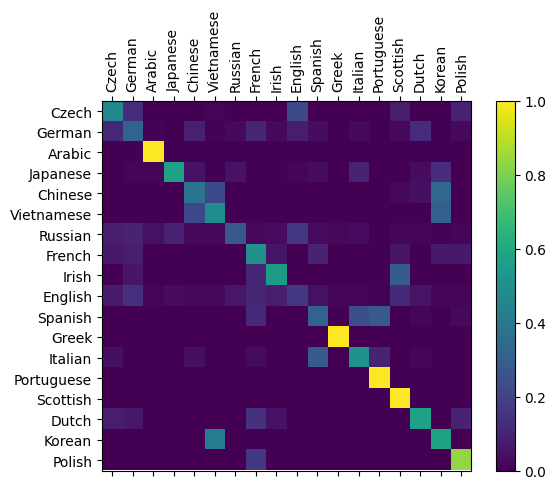

In [213]:
import matplotlib.pyplot as plt


# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)

for x,l,y in train_loader: # choose train or test
    x = x.to(device) #, y.to(device)
    yhat, h = rnn(x,l)
    # print(yhat.size())
    guess = yhat.to('cpu').argmax(1)
    confusion[y,guess] += 1

# # Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticks(range(n_categories), labels=all_categories, rotation=90)
ax.set_yticks(range(n_categories), labels=all_categories)

plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Exercises
=========

-   Try with a different dataset of line -\> category, for example:
    -   Any word -\> language
    -   First name -\> gender
    -   Character name -\> writer
    -   Page title -\> blog or subreddit
-   Get better results with a bigger and/or better shaped network
    -   Add more linear layers
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network


# Construction du sujet à partir de la correction

In [1]:
### <CORRECTION> ###
import re
# transformation de cet énoncé en version étudiante

fname = "4_2_char_rnn-corr.ipynb" # ce fichier
fout  = fname.replace("-corr","")

# print("Fichier de sortie: ", fout )

f = open(fname, "r")
txt = f.read()
 
f.close()

f2 = open(fout, "w")
f2.write(re.sub("<CORRECTION>.*?(</CORRECTION>)"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###